<h1 align="center">Chinese eligibility criteria classification using Naive Bayes (NB)</h1>

In this notebook, we will 

<ol>
    <li>convert criteria sentence to feature vector by Bert-as-Service, </li> 
    <li>train Naive Bayes  model for criteria sentence classification, </li>
    <li>and evalute the performance in test data.</li>
</ol>

Data
* 30644 critering sentences for training
* 7697 critering sentences for testing
* 44 semantic categories

|#|group topics|semantic categories|
|---|---|----
|1|`Health Status`|`Disease` `Symptom` `Sign` `Pregnancy-related Activity` `Neoplasm Status` `Non-Neoplasm Disease Stage` `Allergy Intolerance` `Organ or Tissue Status` `Life Expectancy` `Oral related`
|2|`Treatment or Health Care`|`Pharmaceutical Substance or Drug` `Therapy or Surgery` `Device` `Nursing`
|3|`Diagnostic or Lab Test`|`Diagnostic` `Laboratory Examinations` `Risk Assessment` `Receptor Status`
|4|`Demographic Characteristics`|`Age` `Special Patient Characteristic` `Literacy` `Gender` `Education` `Address` `Ethnicity`
|5|`Ethical Consideration`|`Consent` `Enrollment in other studies` `Researcher Decision` `Capacity` `Ethical Audit` `Compliance with Protocol`
|6|`Lifestyle Choice`|`Addictive Behavior` `Bedtime` `Exercise` `Diet` `Alcohol Consumer` `Sexual related` `Smoking Status` `Blood Donation`
|7|`Data or Patient Source`|`Encounter` `Disabilities` `Healthy` `Data Accessible`
|8|`Other`|`Multiple`

### Bert-as-service

<ol>
<li>download <a href=https://github.com/hanxiao/bert-as-service>bert-as-service</a></li>

``` shell
pip install bert-serving-server  # server
pip install bert-serving-client  # client, independent of `bert-serving-server
```
<br>
<li>download chinese_L-12_H-768_A-12</li>
<br>
<li>start bert-as-service in terminal</li>
    
```shell
bert-serving-start -model_dir chinese_L-12_H-768_A-12 -num_worker=4  -max_seq_len=50
```
<br>  
<li>test bert-as-service</li>
    
```python
from bert_serving.client import BertClient
bc = BertClient()
v = bc.encode(["4.年龄小于65岁。", "存在严重的合并症者"])
print(v.shape)
print(v)  
```
<br>
</ol>

***

load packages

In [1]:
from __future__ import division

import os
import codecs
import time 
import math
import pickle

import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV # 
from sklearn.naive_bayes import GaussianNB

%matplotlib inline 

## Load data

### train data

In [2]:
train_file = "../data/train.txt" 
train_data = pd.read_csv(train_file, sep="\t", header=None, names=["id", "category", "sentence"])

In [3]:
print("train data size：{}".format(len(train_data)))
print("train dara example：")
train_data.head(5)

train data size：30644
train dara example：


,id,category,sentence
0,s1,Therapy or Surgery,研究开始前30天内，接受过其他临床方案治疗；
1,s2,Sign,（9）严重的听力或者视力损害
2,s3,Addictive Behavior,10)现在或曾经滥用药物或酗酒，或者每天饮用相当于30毫升酒精的酒精饮料。
3,s4,Age,4.年龄小于65岁。
4,s5,Disease,⑧有精神疾病患者；


categories and counts

                            category  count
0                 Addictive Behavior    362
1                            Address     42
2                                Age   1221
3                   Alcohol Consumer     23
4                Allergy Intolerance    895
5                            Bedtime     25
6                     Blood Donation     40
7                           Capacity    218
8           Compliance with Protocol    500
9                            Consent   1767
10                   Data Accessible     95
11                            Device    168
12                        Diagnostic   1645
13                              Diet     81
14                      Disabilities     25
15                           Disease   6820
16                         Education     27
17                         Encounter     94
18       Enrollment in other studies    686
19                     Ethical Audit     23
20                         Ethnicity     18
21                          Exer

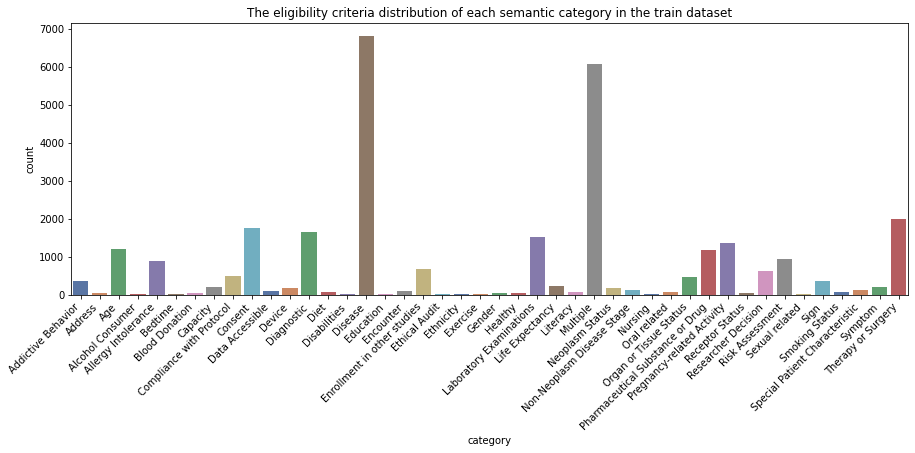

In [4]:
category_count = train_data.groupby(['category'], as_index=False)['category'].agg({'count': 'count'})
fig, ax = plt.subplots(figsize=(15, 5))
fig = sns.barplot(x=category_count["category"], y=category_count["count"], palette="deep", ax=ax)
_ = ax.set_xticklabels(labels=category_count["category"], rotation=45, ha='right')
ax.set_title("The eligibility criteria distribution of each semantic category in the train dataset")
print(category_count)

### test data

In [5]:
test_file = "../data/test.txt" 
test_data = pd.read_csv(test_file, sep="\t", header=None, names=["id", "category", "sentence"])

In [6]:
print("test data size：{}".format(len(test_data)))
print("test dara example：")
test_data.head(5)

test data size：7697
test dara example：


,id,category,sentence
0,s1,Multiple,2）性别不限，年龄18～70岁；
1,s2,Multiple,（1）以原发性胃癌为诊断入院，年龄在18岁至70岁之间的患者；
2,s3,Disease,（6）合并造血系统或恶性肿瘤等严重原发性疾病；
3,s4,Researcher Decision,-其他研究者认为不适合参加本研究的患者
4,s5,Capacity,3、儿童家长能回答或看懂研究用量表者。


categories and counts

                            category  count
0                 Addictive Behavior     88
1                            Address     12
2                                Age    305
3                   Alcohol Consumer      6
4                Allergy Intolerance    223
5                            Bedtime     12
6                     Blood Donation     11
7                           Capacity     56
8           Compliance with Protocol    120
9                            Consent    433
10                   Data Accessible     25
11                            Device     46
12                        Diagnostic    417
13                              Diet     23
14                      Disabilities      7
15                           Disease   1698
16                         Education      7
17                         Encounter     25
18       Enrollment in other studies    174
19                     Ethical Audit     11
20                         Ethnicity      5
21                          Exer

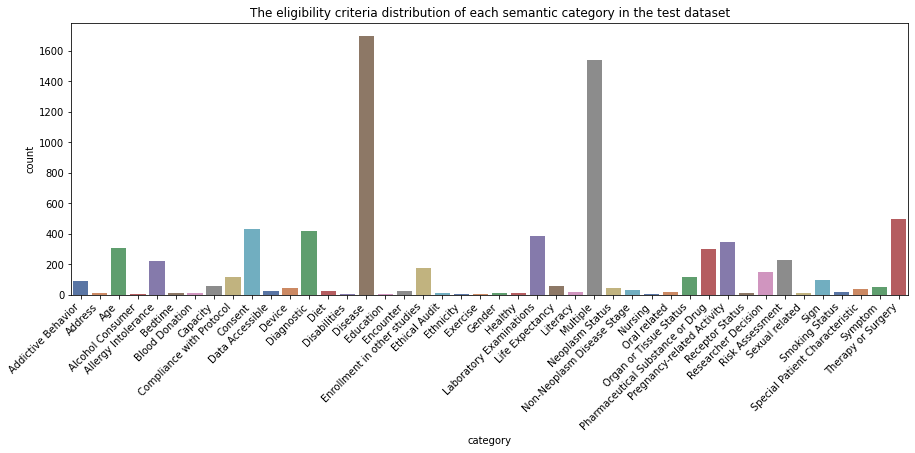

In [7]:
category_count = test_data.groupby(['category'], as_index=False)['category'].agg({'count': 'count'})
fig, ax = plt.subplots(figsize=(15, 5))
fig = sns.barplot(x=category_count["category"], y=category_count["count"], palette="deep", ax=ax)
_ = ax.set_xticklabels(labels=category_count["category"], rotation=45, ha='right')
ax.set_title("The eligibility criteria distribution of each semantic category in the test dataset")
print(category_count)

## Feature construction

**convert labels to number or number to labels.**

In [8]:
labels = ["Disease","Symptom","Sign","Pregnancy-related Activity","Neoplasm Status","Non-Neoplasm Disease Stage",
        "Allergy Intolerance","Organ or Tissue Status","Life Expectancy","Oral related",
        "Pharmaceutical Substance or Drug","Therapy or Surgery","Device","Nursing","Diagnostic",
        "Laboratory Examinations","Risk Assessment","Receptor Status","Age","Special Patient Characteristic",
        "Literacy","Gender","Education","Address","Ethnicity","Consent","Enrollment in other studies",
        "Researcher Decision","Capacity","Ethical Audit","Compliance with Protocol","Addictive Behavior",
        "Bedtime","Exercise","Diet","Alcohol Consumer","Sexual related","Smoking Status","Blood Donation",
        "Encounter","Disabilities","Healthy","Data Accessible","Multiple"]
label2index = dict()
index2label = dict()
for (i, label) in enumerate(labels):
    label2index[label] = i
    index2label[i] = label

**choice 1: convert criteria sentences into feature matrix using bert-as-service inline**

In [ ]:
X_train = bc.encode(list(train_data["sentence"]))
y_train = train_data["category"].apply(lambda x: label2index.get(x))
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)

In [ ]:
X_test = np.array(bc.encode(list(test_data["sentence"])))
y_test = np.array(test_data["category"].apply(lambda x: label2index.get(x)))
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

save the feature as .npy file

In [ ]:
np.save("../data/feature_matraix (by bert-as-service)/X_train.npy", X_train)
np.save("../data/feature_matraix (by bert-as-service)/X_test.npy", X_test)

**choice 2: load the feature from file, (we save as .npy format)**

In [10]:
X_train = np.load("../data/feature_matraix (by bert-as-service)/X_train.npy")
y_train = train_data["category"].apply(lambda x: label2index.get(x))
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)

X_train shape: (30644, 768) y_train shape: (30644,)


In [11]:
X_test = np.load("../data/feature_matraix (by bert-as-service)/X_test.npy")
y_test = np.array(test_data["category"].apply(lambda x: label2index.get(x)))
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

X_test shape: (7697, 768) y_test shape: (7697,)


## Naive Bayes ( using scikit-learn)

### training

In [12]:
start_time = time.time()
model = GaussianNB()
model.fit(X_train, y_train)
print("training took {}s!".format(time.time() - start_time))

training took 0.31359028816223145s!


### predict

predict label of test data

In [13]:
pred_test = model.predict(X_test)
print(pred_test)

[18 43  0 ... 36 36 19]


save predict results

In [14]:
with codecs.open("NB_test_pred.txt", "w", encoding="utf-8") as outf:
    for (i, c, s) in zip(test_data["id"], pred_test, test_data["sentence"]):
        outf.write("{}\t{}\t{}\r\n".format(i, index2label.get(c), s))

### evaluation

show predict results by confusion matrix

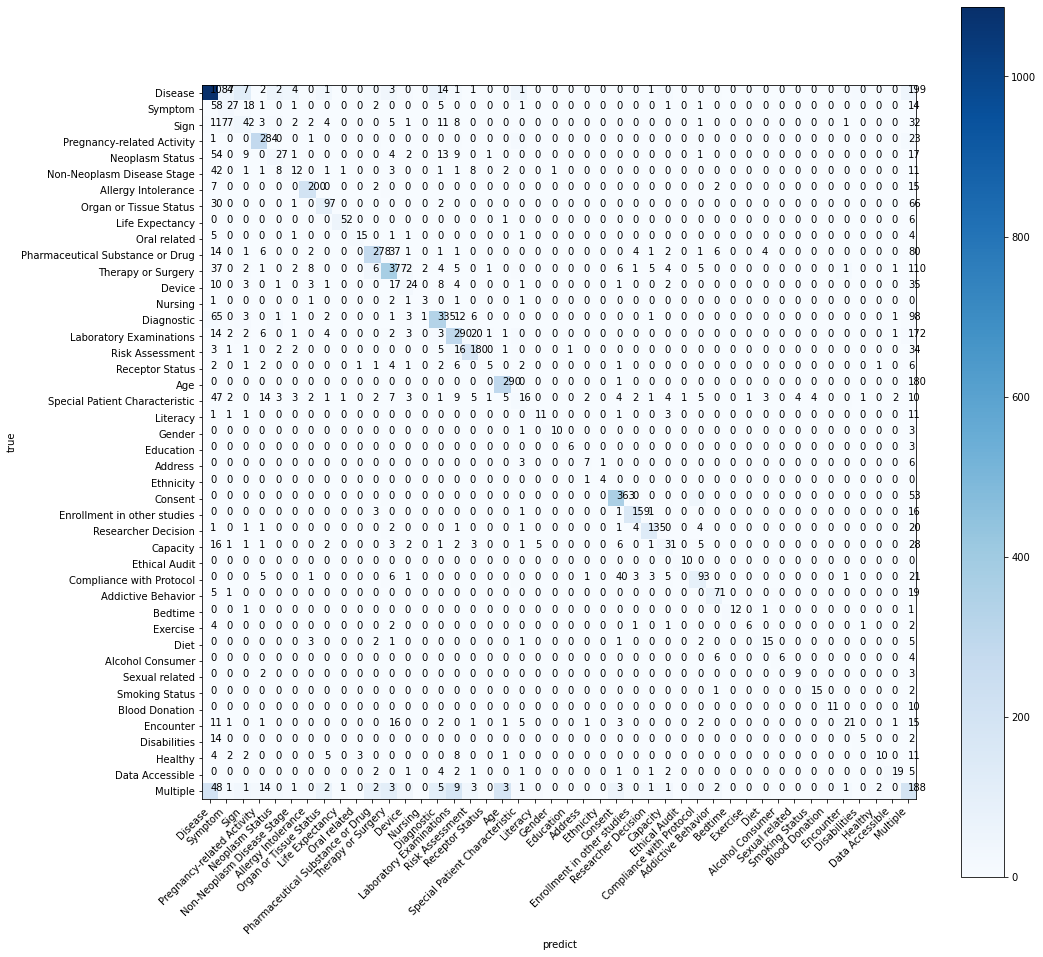

In [15]:
confusion = confusion_matrix(y_test, pred_test)
plt.figure(figsize=(16,16))
plt.imshow(confusion, cmap=plt.cm.Blues)
indices = range(len(confusion))
plt.xticks(indices, labels, rotation=45, ha='right')
plt.yticks(indices, labels)
plt.colorbar()
plt.xlabel('predict')
plt.ylabel('true')
for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index])

precision, recall, F1 score

In [16]:
import evaluation # our defined evaluation metrics.
results = evaluation.Record_results('../data/test.txt', 'NB_test_pred.txt')
evaluation = evaluation.Evaluation(results.records)

**************************************** Evaluation results*****************************************
                                       Precision.       Recall.          f1.            
                 Addictive Behavior    0.7396           0.8068           0.7717         
                            Address    0.4118           0.5833           0.4828         
                                Age    0.6157           0.9508           0.7474         
                   Alcohol Consumer    0.3750           1.0000           0.5455         
                Allergy Intolerance    0.8850           0.8969           0.8909         
                            Bedtime    0.8000           1.0000           0.8889         
                     Blood Donation    0.5238           1.0000           0.6875         
                           Capacity    0.2844           0.5536           0.3758         
           Compliance with Protocol    0.5167           0.7750           0.6200         
         

### save models

In [17]:
model_save_file = "NB_model.mkl"
pickle.dump(model, open(model_save_file, 'wb'))